In [1]:
import sys
sys.path.insert(0, "../")

In [2]:
import re
import string

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xml.sax.saxutils import unescape
import demoji
import numpy as np
from bs4 import BeautifulSoup
from unidecode import unidecode
from nltk.corpus import stopwords
from wordcloud import WordCloud
from colour import Color

from data import parse_dataset

# Parse the dataset

In [3]:
data = parse_dataset("../../datasets", "en", to_pandas=True)
data.head(3)

,author_id,truth_value,tweet_1,tweet_2,tweet_3,tweet_4,tweet_5,tweet_6,tweet_7,tweet_8,...,tweet_91,tweet_92,tweet_93,tweet_94,tweet_95,tweet_96,tweet_97,tweet_98,tweet_99,tweet_100
0,06ct0t68y1acizh9eow3g5rhancrppr8,1,Courteney Cox Recreates Classic Friends Scene ...,The Jonas Brothers Have Secret Concert Days Af...,Ariana Grande Sends Heartfelt Message to Her F...,7 of the Biggest Bombshells From Jordyn Woods'...,Fyre Festival's Andy King Spills New Details o...,Watch Travis Scott Take an Adorable Phone Call...,See What Tyler Henry Really Thinks About His K...,Kim Kardashian Says She Had ''One of the Best ...,...,It's Pauly D Like You've Never Seen Him Before...,Hailey Baldwin Sends Her ''Lover'' Justin Bieb...,You Won't Believe How Much Money Property Brot...,"You Have to See Nicki Minaj's $450,000 Rolls-R...",How Maddie Poppe and Caleb Lee Hutchinson Are ...,What Do the Kids of the Grey's Anatomy Cast Th...,Inside Nikki Bella's Romantic Date Night With ...,How Justin Bieber Celebrated His 25th Birthday...,Matthew McConaughey's 3 Stylish Kids Make a Ra...,Royal Bartender! Kate Middleton Pours a Pint o...
1,071nxc49ihpd0jlfmvn2lghtayy3b5n9,0,Amber Smith “Kandy Halloween: Return of the Ha...,Kourtney Kardashian Reveals Scott Disick 'Chec...,Serena Williams Steps Out at the 2019 Met Gala...,See the campiest looks from 2019 Met Gala pink...,Trouble in Paradise? Kris Jenner and Corey Gam...,Bethenny Frankel Wants To Sell SkinnyGirl Beca...,Everything Kim Kardashian Has Said About Surro...,Kim Kardashian Confirms 4th Baby Not Here Yet ...,...,Michelle Williams Fuels Reconciliation Rumors ...,Dream Kardashian Flaunts Her Long Curly Locks ...,Charlize Theron Finally Addresses Her Rumored ...,Scott Disick Doesn’t Want To ‘Disrespect’ Sofi...,Kim Kardashian Lobbying for Systematic Change ...,Cardi B and Nicki Minaj Both Hit Met Gala Red ...,Jennifer Lopez and Alex Rodriguez Step Out for...,Jessie J Puts Her Misspelled Tattoo on Display...,Meghan Markle Gives Birth To Baby Boy! #URL#,Amy Schumer Cradles Up to Newborn Son Gene In ...
2,09py5qescynpnnckmzueqzr2y49moh1o,0,Rachel Bilson Was Asked Point-Blank if She’s D...,Bill Hader and Rachel Bilson make red carpet d...,What Do The Stars Say About Rachel Bilson? (12...,Celebrities front row at NYFW 2020 - Page Six ...,Rachel Bilson dating Bill Hader? - Arizona Dai...,Bill Hader and Rachel Bilson Confirm Relations...,How Did Rachel Bilson and Bill Hader Meet? - Y...,Rachel Bilson’s Golden Highlights Made For The...,...,Rachel Bilson On Helping La Marca Prosecco Lau...,Now This Is an Unexpected Couple - The Cut #UR...,"Love That O.C. Reunion Pic? Well, We've Got So...",Is Rachel Bilson Loved or Hated? New Analysis ...,Never Forget When Bill Hader Parodied Rachel B...,Bill Hader and Rachel Bilson made their red ca...,Rachel Bilson shops for home furnishings and g...,"Hold Up, Are Rachel Bilson and Bill Hader a Co...","Bill Hader, Rachel Bilson continue to fuel rum...",New couple alert! Bill Hader takes Rachel Bils...


In [15]:
data_truth = data.loc[data["truth_value"] == "0"].iloc[:, 2:].values
data_fake = data.loc[data["truth_value"] == "1"].iloc[:, 2:].values
color_t, color_te = "#1f77b4", "#1a669c"
color_f, color_fe = "#ff7f0e", "#e6720e"

print("%d truthful users, %d fake users" % (len(data_truth), len(data_fake)))

127 truthful users, 127 fake users


# Helper functions

In [5]:
digits = set("0123456789")
printable = set(string.printable)
punctuation = set(string.punctuation)
punctuation.add("…")
punctuation.remove('#')

In [6]:
def clean_text(text, remove_punc=True, remove_non_print=True, remove_emojis=True, 
              remove_digits=True, remove_tags=False):
    """ Clean text by removing certain characters (e.g. punctuation) """
    if remove_emojis:
        text = demoji.replace(text, "")
        
    chars = []
    for char in text:
        if not ((remove_punc and char in punctuation) or
            (remove_non_print and char not in printable) or
            (remove_digits and char in digits)):
            chars.append(char)
        
    cleaned = "".join(chars)
    if remove_tags:
        return re.sub('#[A-Z]+#', "", cleaned)
    
    return cleaned

# Tweet lengths

## Number of characters used in tweets, per user
* Count the number of characters in a users 100 tweets and then take the mean and median

In [31]:
def tweet_lengths_per_user(data_array):
    """ Returns a Numpy array of average and median tweet lengths (in chars) for each user """
    char_lens = np.asarray([
        [len(tweet) for tweet in tweet_feed]
        for tweet_feed in data_array
    ])
    means = np.asarray([np.mean(tweet_lens) for tweet_lens in char_lens])
    medians = np.asarray([np.median(tweet_lens) for tweet_lens in char_lens])
    return means, medians

Average user tweet lengths (in characters), from their 100 tweets
Min: 46.0; Max: 131.0


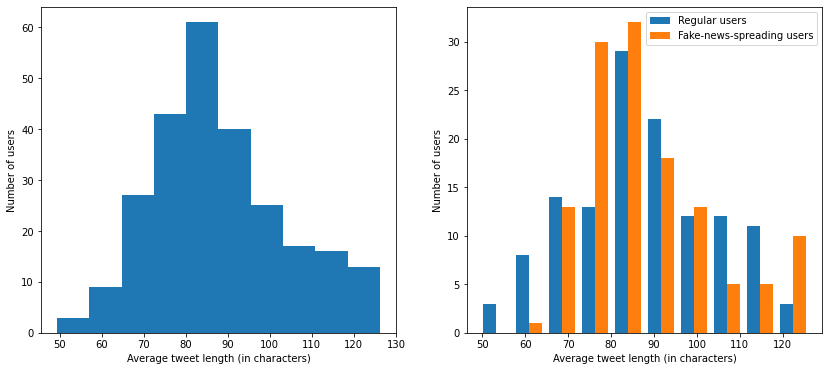

In [32]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

data_lens = tweet_lengths_per_user(data.iloc[:, 2:].values)
truthful_lens = tweet_lengths_per_user(data_truth)
fake_lens = tweet_lengths_per_user(data_fake)

# All tweets plot
ax[0].hist(data_lens[0])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Average tweet length (in characters)")

# Truth label plot
ax[1].hist((truthful_lens[0], fake_lens[0]), label=("Regular users", "Fake-news-spreading users"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Average tweet length (in characters)")
ax[1].legend()
print("Average user tweet lengths (in characters), from their 100 tweets")
print(f"Min: {np.min(data_lens)}; Max: {np.max(data_lens)}")

Median tweet lengths (in characters), from their 100 tweets


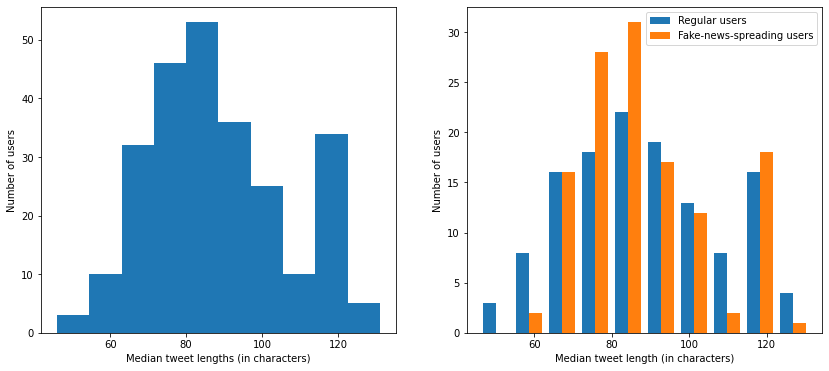

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

# All tweets plot
ax[0].hist(data_lens[1])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Median tweet lengths (in characters)")

# Truth label plot
ax[1].hist((truthful_lens[1], fake_lens[1]), label=("Regular users", "Fake-news-spreading users"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Median tweet length (in characters)")
ax[1].legend()
print("Median tweet lengths (in characters), from their 100 tweets")

Findings:
* Truthful users are more likely to write very short tweets
* Fake users write more mid-length tweets than truthful users

## Number of words used in tweets, per user
* Count the number of words in a users 100 tweets and then take the mean and median

In [34]:
def tweets_to_words(data_array):
    """ Returns a Numpy array where tweets have been split by spaces (after removing punctuation) """
    return np.asarray([
        [
            clean_text(tweet, 
                       remove_punc=True, 
                       remove_non_print=False, 
                       remove_emojis=True, 
                       remove_digits=True, 
                       remove_tags=True
                      ).split(" ") for tweet in user_tweets
        ] for user_tweets in data_array
    ])

Average tweet lengths (in words)


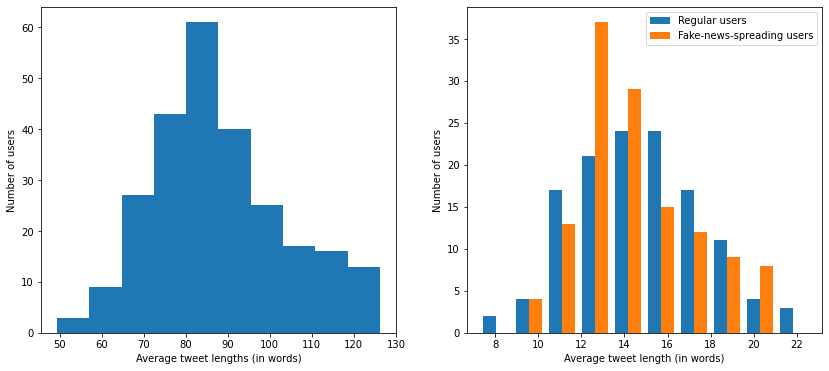

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

data_lens_words = tweet_lengths_per_user(
    tweets_to_words(data.iloc[:, 2:].values))
truthful_lens_words = tweet_lengths_per_user(tweets_to_words(data_truth))
fake_lens_words = tweet_lengths_per_user(tweets_to_words(data_fake))

# All tweets plot
ax[0].hist(data_lens[0])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Average tweet lengths (in words)")

# Truth label plot
ax[1].hist((truthful_lens_words[0], fake_lens_words[0]), label=("Regular users", "Fake-news-spreading users"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Average tweet length (in words)")
ax[1].legend()
print("Average tweet lengths (in words)")

Median tweet lengths (in words)


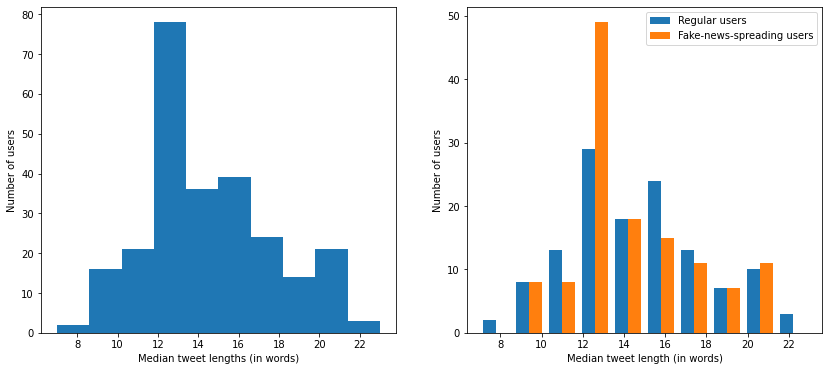

In [36]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

# All tweets plot
ax[0].hist(data_lens_words[1])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Median tweet lengths (in words)")

# Truth label plot
ax[1].hist((truthful_lens_words[1], fake_lens_words[1]), label=("Regular users", "Fake-news-spreading users"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Median tweet length (in words)")
ax[1].legend()
print("Median tweet lengths (in words)")

Chars: Min: 46.0; Max: 131.0


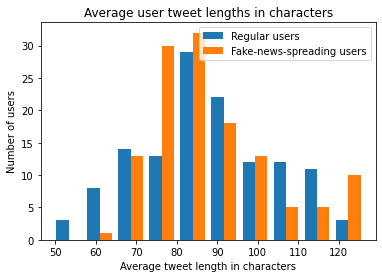

In [37]:
# plt.figure(figsize=(8, 6), dpi=300)
plt.hist((truthful_lens[0], fake_lens[0]), label=("Regular users", "Fake-news-spreading users"))
plt.ylabel("Number of users")
plt.xlabel("Average tweet length in characters")
plt.title("Average user tweet lengths in characters")
plt.legend()
print(f"Chars: Min: {np.min(data_lens)}; Max: {np.max(data_lens)}")

Words: Min: 7.0; Max: 23.0


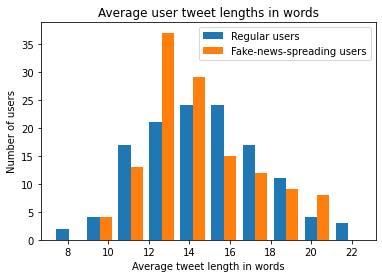

In [38]:
# plt.figure(figsize=(8, 6), dpi=300)
plt.hist((truthful_lens_words[0], fake_lens_words[0]), label=("Regular users", "Fake-news-spreading users"))
plt.ylabel("Number of users")
plt.xlabel("Average tweet length in words")
plt.title("Average user tweet lengths in words")
plt.legend()
print(f"Words: Min: {np.min(data_lens_words)}; Max: {np.max(data_lens_words)}")

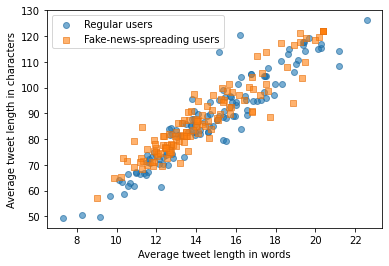

In [50]:
# plt.figure(figsize=(8, 6), dpi=300)
plt.scatter(truthful_lens_words[0], truthful_lens[0], label="Regular users",
            color=color_t, alpha=0.6, edgecolors=color_te)
plt.scatter(fake_lens_words[0], fake_lens[0], label="Fake-news-spreading users",
            color=color_f, alpha=0.6, edgecolors=color_fe, marker="s")
plt.ylabel("Average tweet length in characters")
plt.xlabel("Average tweet length in words")
plt.legend()

Findings:
* Truthful users typically use the fewest words or the most words in tweets - shown in both mean and medians
* Similar to with char lengths, fake users normally use mid-length tweets (when measuring length by words)

## Word lengths of users
* Count the lengths of all words used by a user, and then take the mean and median

Findings:
* Fake news authors use (on average) longer words, while truthful authors use shorter words

In [94]:
def tweets_to_flattened_words(data_array):
    """ Returns a Numpy array where tweets have been split by spaces (after removing punctuation) and flattened """
    return np.asarray([
        [
            word for tweet in tweet_feed for word in clean_text(
                tweet, remove_punc=True, remove_non_print=False, 
                remove_emojis=True, remove_digits=True, remove_tags=True).split()
        ] for tweet_feed in data_array
    ])

Average word lengths


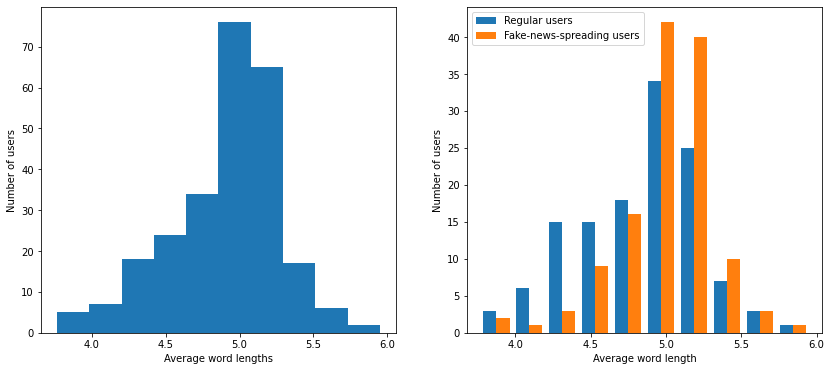

In [95]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

data_lens = tweet_lengths_per_user(tweets_to_flattened_words(data.iloc[:, 2:].values))
truthful_lens = tweet_lengths_per_user(tweets_to_flattened_words(data_truth))
fake_lens = tweet_lengths_per_user(tweets_to_flattened_words(data_fake))

# All tweets plot
ax[0].hist(data_lens[0])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Average word lengths")

# Truth label plot
ax[1].hist((truthful_lens[0], fake_lens[0]), label=("Regular users", "Fake-news-spreading users"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Average word length")
ax[1].legend()
print("Average word lengths")

Median word lengths


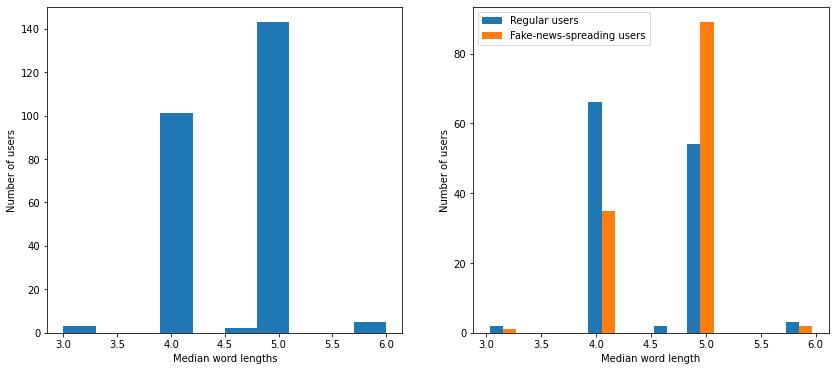

In [96]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

# All tweets plot
ax[0].hist(data_lens[1])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Median word lengths")

# Truth label plot
ax[1].hist((truthful_lens[1], fake_lens[1]), label=("Regular users", "Fake-news-spreading users"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Median word length")
ax[1].legend()
print("Median word lengths")

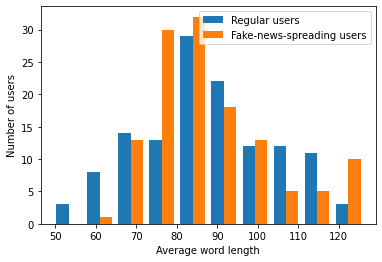

In [51]:
# plt.figure(figsize=(8, 6), dpi=300)
plt.hist((truthful_lens[0], fake_lens[0]), label=("Regular users", "Fake-news-spreading users"))
plt.ylabel("Number of users")
plt.xlabel("Average word length")
plt.legend()

Findings:
* Truthful users use shorter words
* Fake users use longer words

# Types of words used

## Frequent words

In [116]:
def tweets_to_word_freq(tweets_data_array):
    """ Returns a dict of words mapped to their frequency (ignoring stopwords) """
    word_freq = dict()
    english_stopwords = set([clean_text(
                word, remove_punc=True, remove_non_print=False, 
                remove_emojis=True, remove_digits=True, remove_tags=True) for word in stopwords.words('english')])

    words = [word for tweet in tweets_data_array for word in clean_text(
        tweet, remove_punc=True, remove_non_print=False, remove_emojis=True, 
        remove_digits=True, remove_tags=False).split(" ")]

    for word in words:
        if word not in english_stopwords:
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1
    
    return word_freq

In [117]:
# Wordcloud data
data_freq = tweets_to_word_freq(data.iloc[:, 2:].values.flatten())
truthful_freq = tweets_to_word_freq(data_truth.flatten())
fake_freq = tweets_to_word_freq(data_fake.flatten())

color_map = dict()
for k, v in truthful_freq.items():
    other_v = fake_freq[k] if k in fake_freq else 0
    color_map[k] = v/(v+other_v)

def color_map_func(word, **kwargs):
    color_val = color_map[word] if word in color_map else 0
    return Color(rgb=(1-color_val, color_val, 0)).hex

Wordclouds of frequent words


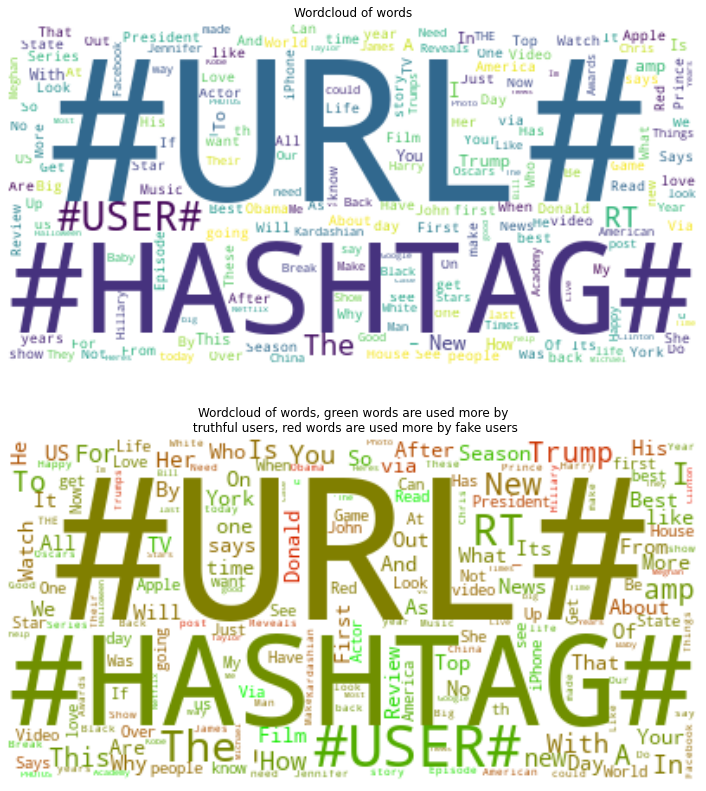

In [118]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(14, 14))

wc = WordCloud(background_color="white")
wc.fit_words(data_freq)
ax[0].imshow(wc, interpolation="bilinear")
ax[0].axis("off")
ax[0].set_title("Wordcloud of words")

wc = WordCloud(background_color="white", color_func=color_map_func)
wc.fit_words(data_freq)
ax[1].imshow(wc, interpolation="bilinear")
ax[1].axis("off")
ax[1].set_title("Wordcloud of words, green words are used more by\n truthful users, red words are used more by fake users")

print("Wordclouds of frequent words")

(-0.5, 999.5, 599.5, -0.5)

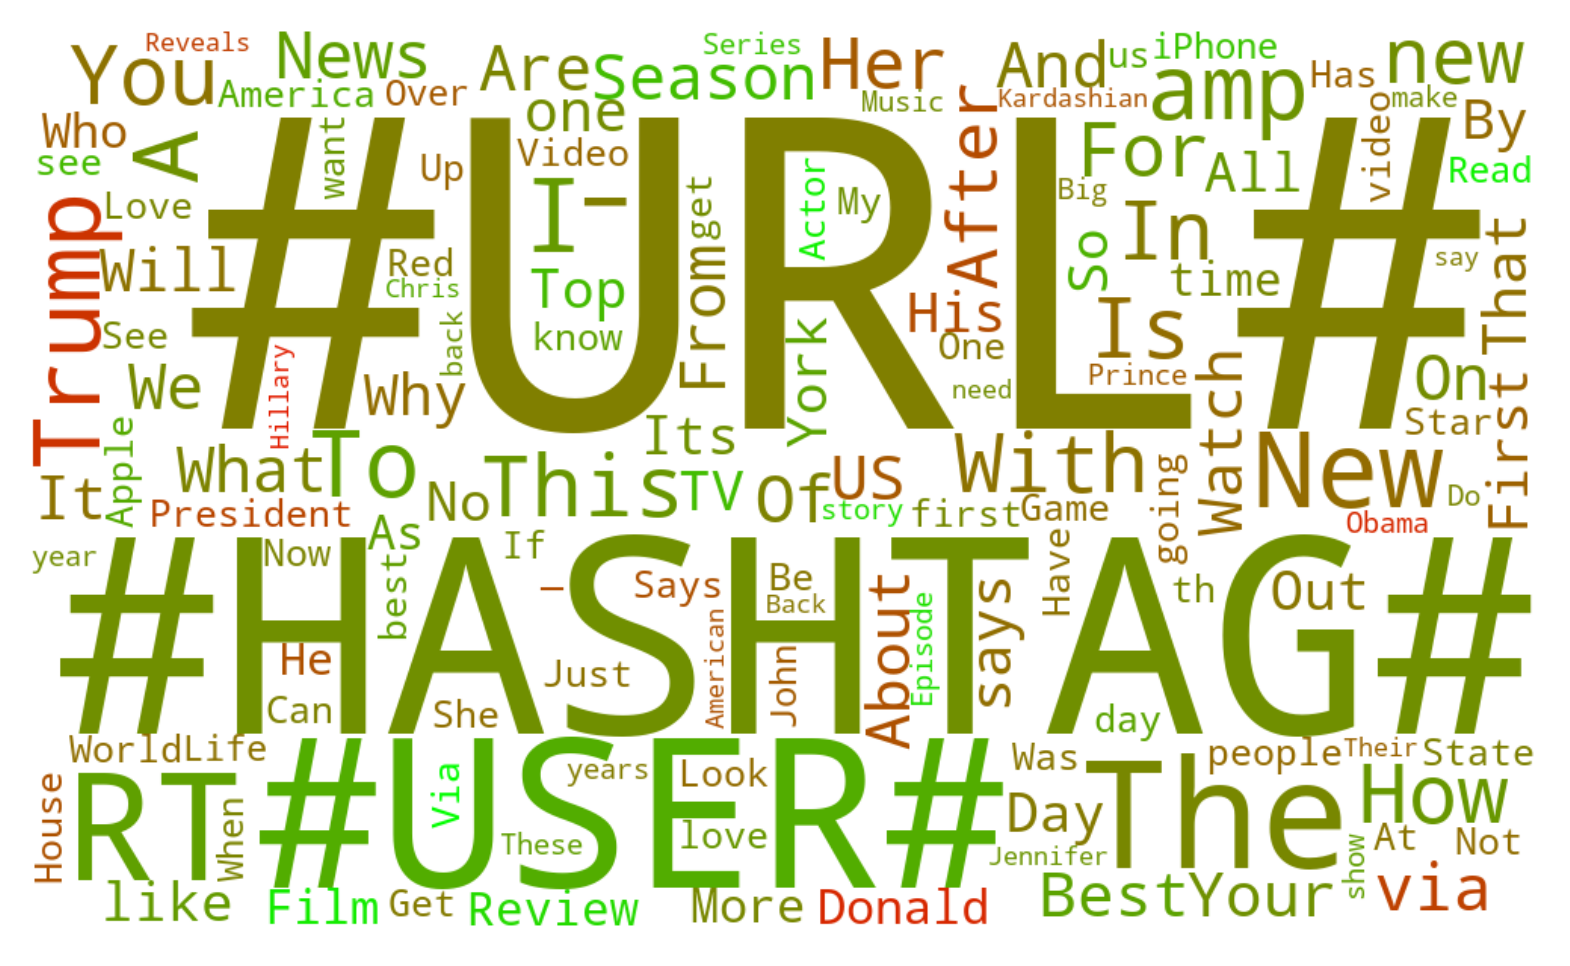

In [120]:
plt.figure(figsize=(8, 4), dpi=300)
wc = WordCloud(background_color="white", color_func=color_map_func, width=1000, height=600, max_words=140, min_word_length=1)
wc.fit_words(data_freq)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

Findings:
* The most-used words are tags (url, hashtag, user, rt)
* User tags seem to be used mostly by truthful users
* 'donald', 'trump', 'obama', 'hillary' seem to be the words most used primarily by fake users

How could I use this?
* Counting the different tags for each user and passing them into a model
* We cannot count raw words like 'trump' or 'obama' as this would limit the future potential of our model. Instead it may be possible to use a remote political API to count usage of political terms instead

## Use of tags

In [25]:
def count_term_in_tweets(tweets_array, term):
    count = [tweet.count(term) for tweet in tweets_array]
    return np.mean(count), np.median(count)

def tweets_to_tag_freq_per_user(data_array):
    return [
        {
            'RT': np.asarray(count_term_in_tweets(user_tweets, 'RT')),
            '#USER#': np.asarray(count_term_in_tweets(user_tweets, '#USER#')),
            '#HASHTAG#': np.asarray(count_term_in_tweets(user_tweets, '#HASHTAG#')),
            '#URL#': np.asarray(count_term_in_tweets(user_tweets, '#URL#')),
        } 
        for user_tweets in data_array
    ]

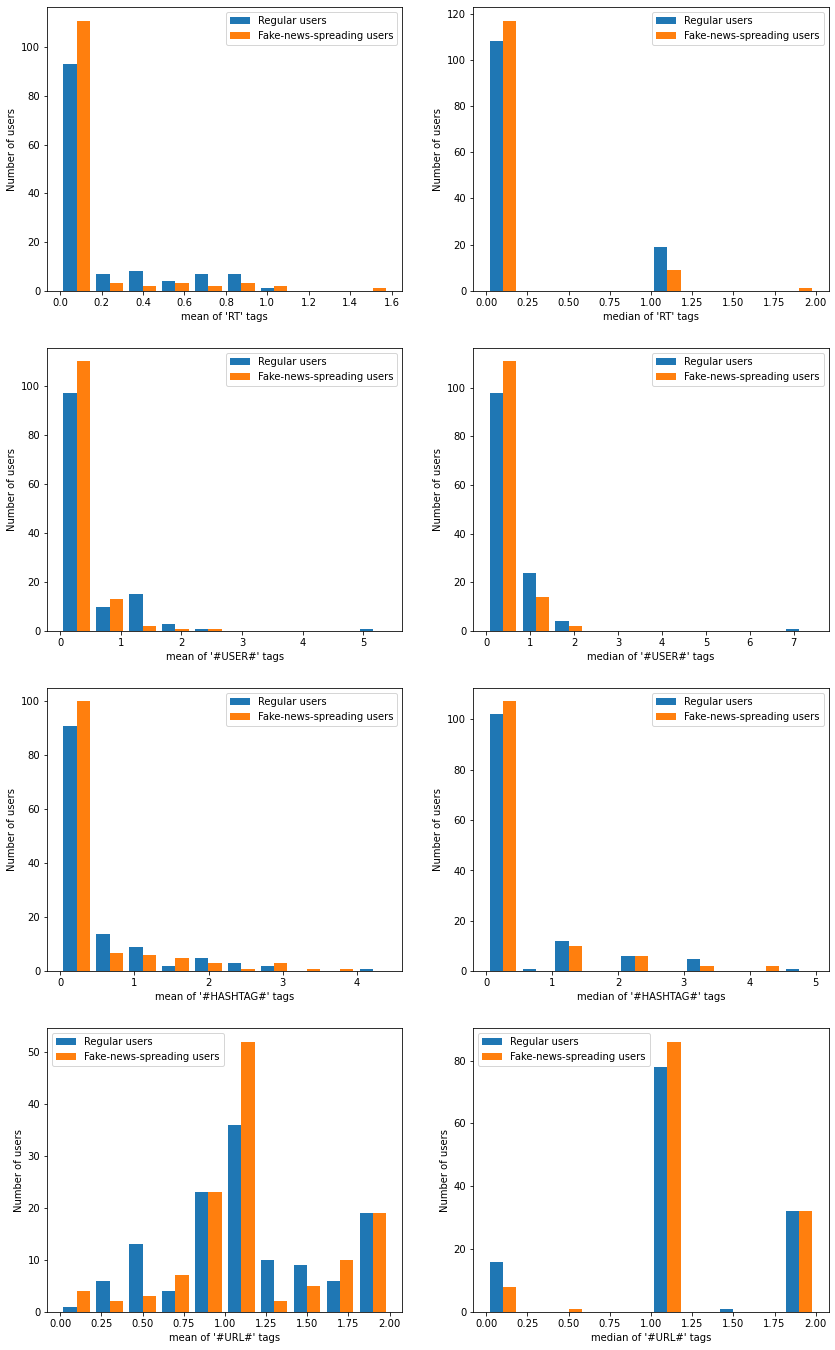

In [26]:
ncols = 2
fig, ax = plt.subplots(nrows=4, ncols=ncols, figsize=(14, 24))

tags = ['RT', '#USER#', '#HASHTAG#', '#URL#']
truthful_terms = tweets_to_tag_freq_per_user(data_truth)
fake_terms = tweets_to_tag_freq_per_user(data_fake)

# Truth label plots
for row, tag in enumerate(tags):
    truthful_hist_data = np.asarray([user[tag] for user in truthful_terms])
    fake_hist_data = np.asarray([user[tag] for user in fake_terms])
    
    for col in range(ncols):  
        ax[row][col].hist(
            (truthful_hist_data[:, col], fake_hist_data[:, col]), label=("Regular users", "Fake-news-spreading users"))
        ax[row][col].set_ylabel("Number of users")
        ax[row][col].set_xlabel(f"{'mean' if col == 0 else 'median'} of '{tag}' tags")
        ax[row][col].legend()

Findings:
* Fake users seem to use fewer RT, #USER#, and #HASHTAG# tags
* However, they generally use more #URL# tags

# Types of characters used

## Letter casing
* Look at the average letter casing of users

In [27]:
def average_char_casing_per_user(data_array):
    """ Returns Numpy arrays of the average character casings (uncased/lowercase and cased/uppercase) """
    uncased = [
        np.mean([sum([c.islower() for c in tweet]) for tweet in tweet_feed]) 
        for tweet_feed in data_array
    ]
    cased = [
        np.mean([sum([c.isupper() for c in tweet]) for tweet in tweet_feed]) 
        for tweet_feed in data_array
    ]
    return uncased, cased

Average user character casing per tweet


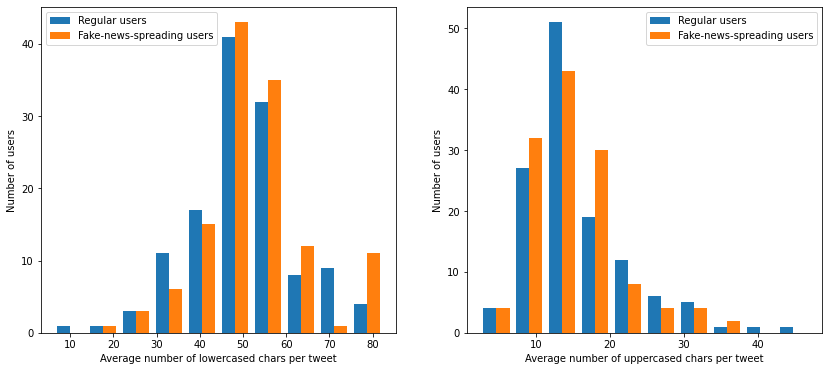

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

truthful_casing = average_char_casing_per_user(data_truth)
fake_casing = average_char_casing_per_user(data_fake)

# Uncased
ax[0].hist((truthful_casing[0], fake_casing[0]), label=("Regular users", "Fake-news-spreading users"))
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Average number of lowercased chars per tweet")
ax[0].legend()

# Cased
ax[1].hist((truthful_casing[1], fake_casing[1]), label=("Regular users", "Fake-news-spreading users"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Average number of uppercased chars per tweet")
ax[1].legend()
print("Average user character casing per tweet")

## Use of emojis

In [29]:
def count_emojis(user_tweets):
    count = 0
    for tweet in user_tweets:
        emojis_found = list(demoji.findall(tweet).keys())
        for emoji in emojis_found:
            count += len(re.findall(emoji, tweet))
    
    return count

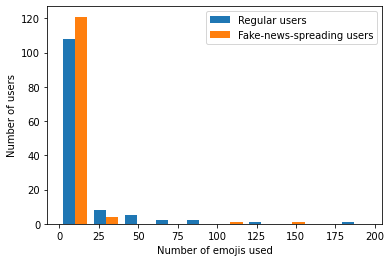

In [122]:
truthful_emojis = [count_emojis(user_tweets) for user_tweets in data_truth]
fake_emojis = [count_emojis(user_tweets) for user_tweets in data_fake]

plt.hist((truthful_emojis, fake_emojis), label=("Regular users", "Fake-news-spreading users"))
plt.xlabel("Number of emojis used")
plt.ylabel("Number of users")
plt.legend()

## Use of punctuation

In [179]:
punc_indices = {
    ".": 0,
    ",": 1,
    ":": 2,
    ";": 3,
    "?": 4,
    "!": 5,
    "…": 6,
}
def average_punc_per_user(data_array):
    """ Returns Numpy array of the average amount of punctuation used """
    results = []
    for tweet_feed in data_array:
        user_results = []
        for tweet in tweet_feed:
            tweet_results = [0 for _ in range(len(punc_indices) + 1)]
            for ch in tweet:
                if ch in punc_indices:
                    tweet_results[punc_indices[ch]] += 1
                elif ch in punctuation:
                    tweet_results[-1] += 1
        
            user_results.append(tweet_results)
        
        results.append(user_results)
    
    # Average each user over tweets
    return np.mean(results, axis=1)

In [180]:
truthful_punc = average_punc_per_user(data_truth)
fake_punc = average_punc_per_user(data_fake)

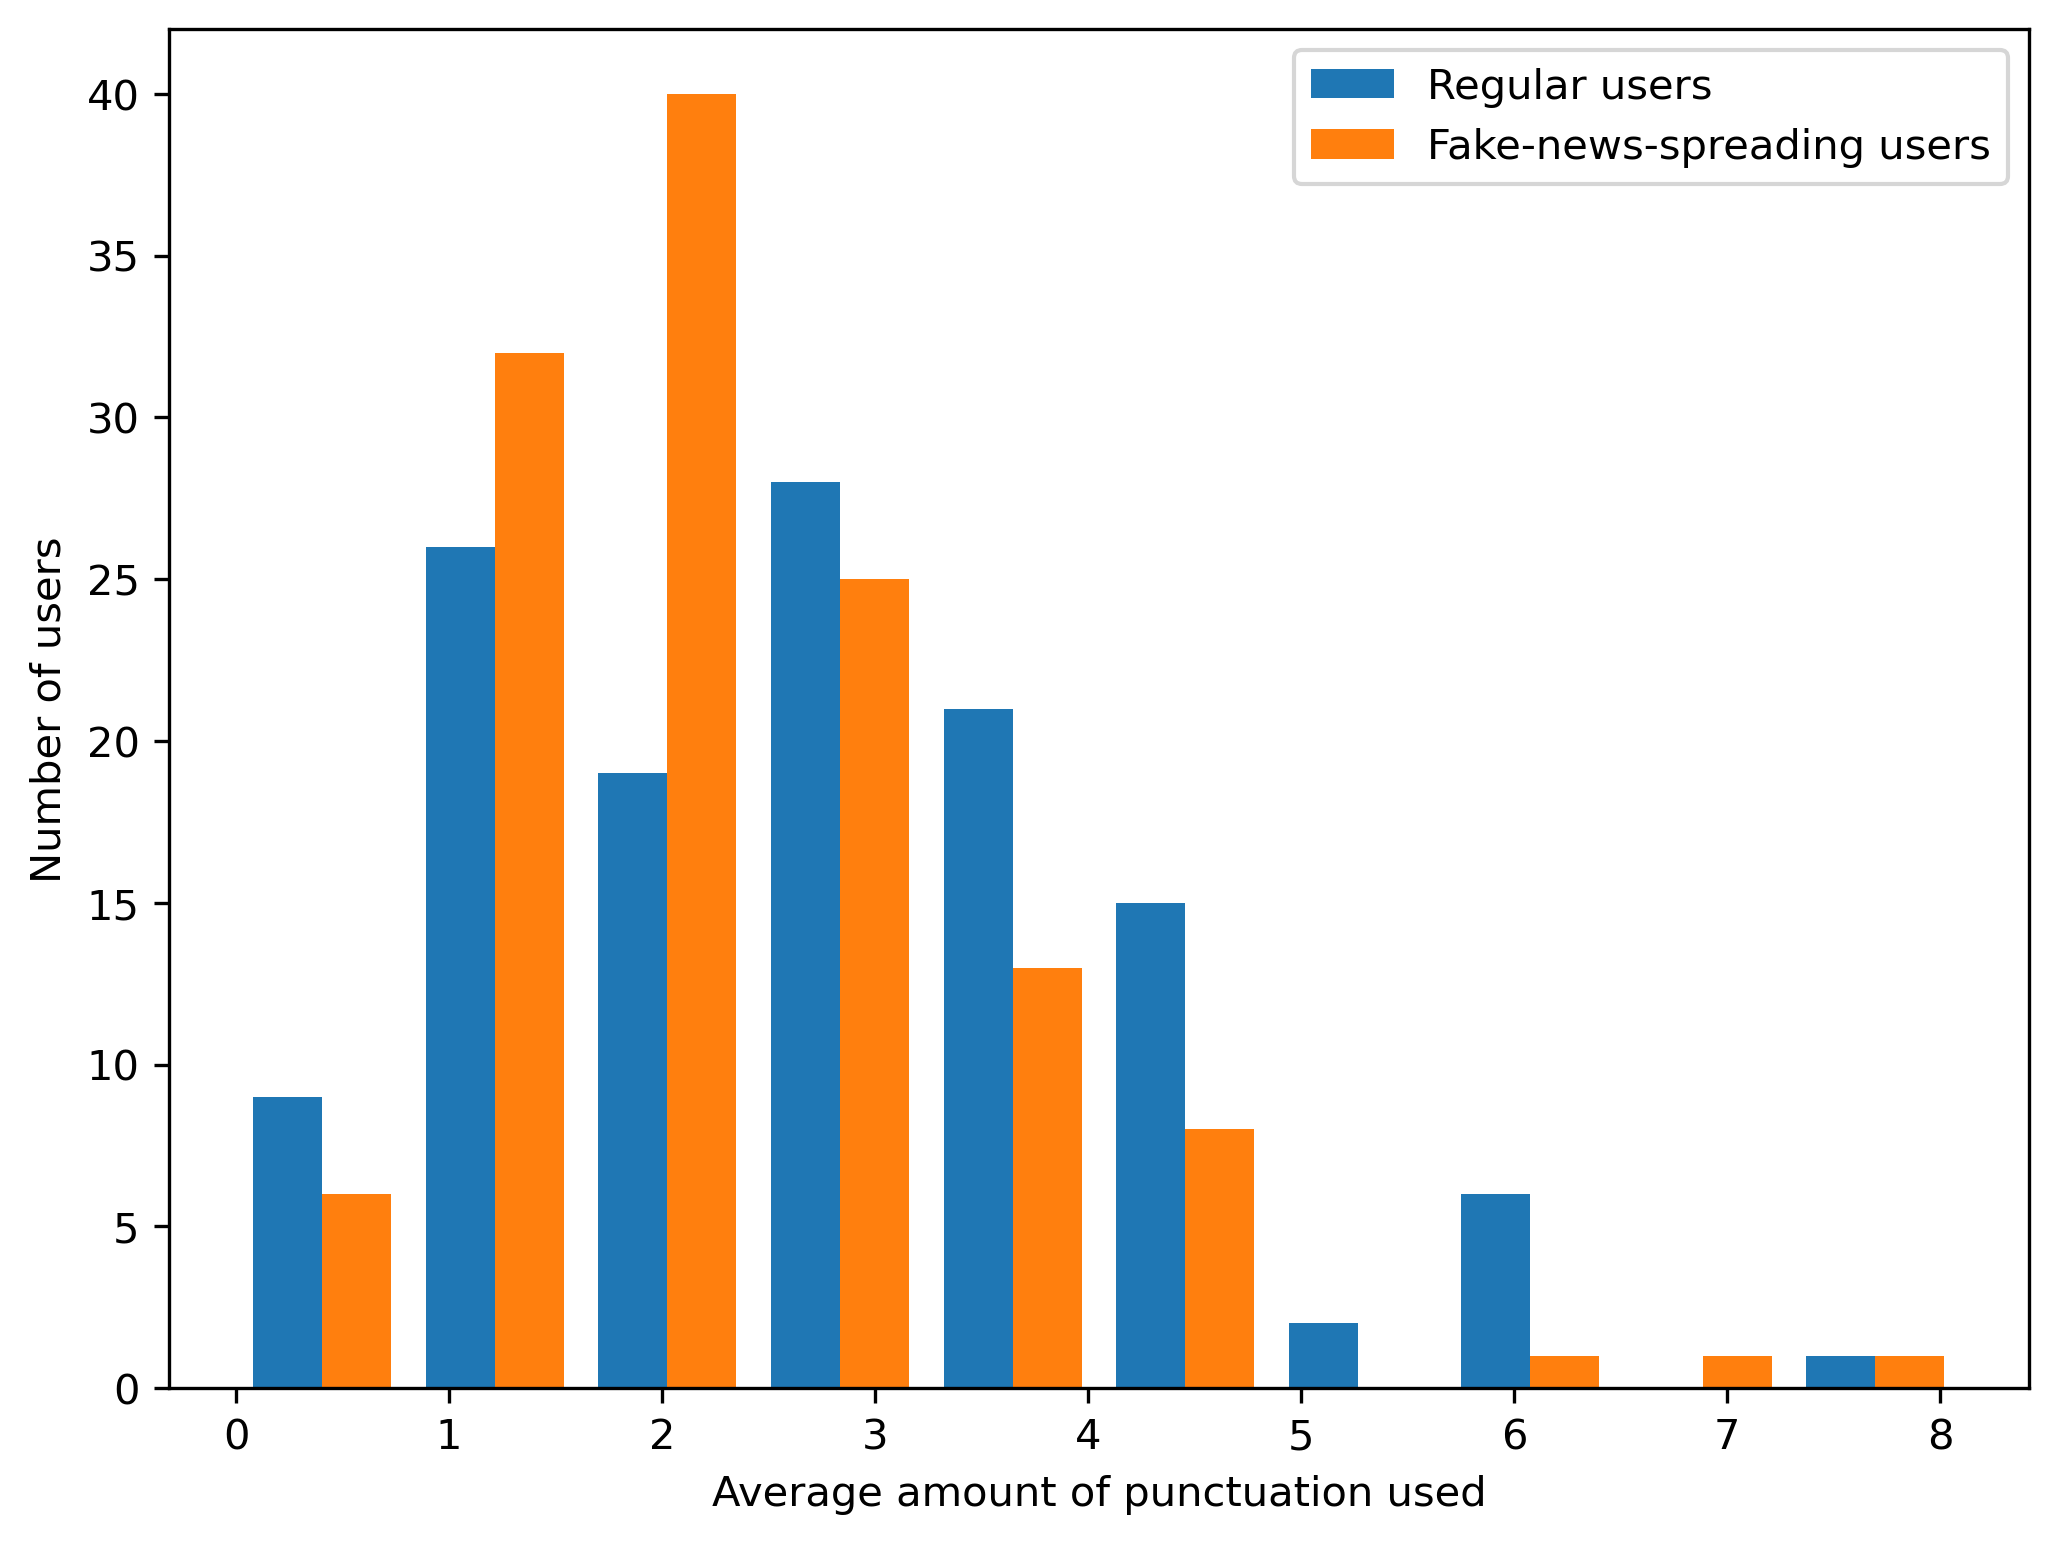

In [166]:
# Average use of punctuation
plt.figure(figsize=(8, 6), dpi=300)
plt.hist([np.sum(truthful_punc, axis=1), np.sum(fake_punc, axis=1)],
         label=["Regular users", "Fake-news-spreading users"])
plt.ylabel("Number of users")
plt.xlabel("Average amount of punctuation used")
plt.legend()

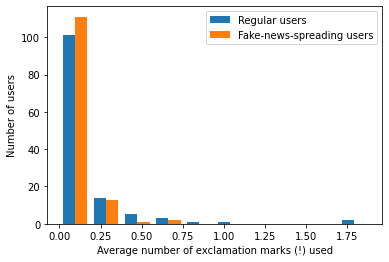

In [198]:
# Average use of exclamation marks
# plt.figure(figsize=(8, 6), dpi=300)
plt.hist([truthful_punc[:, punc_indices["!"]], fake_punc[:, punc_indices["!"]]],
         label=["Regular users", "Fake-news-spreading users"])
plt.ylabel("Number of users")
plt.xlabel("Average number of exclamation marks (!) used")
plt.legend()

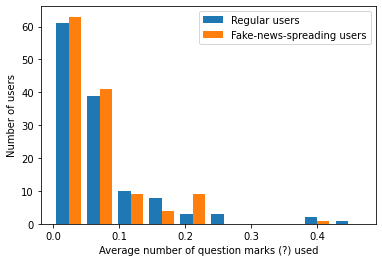

In [197]:
# Average use of question marks
# plt.figure(figsize=(8, 6), dpi=300)
plt.hist([truthful_punc[:, punc_indices["?"]], fake_punc[:, punc_indices["?"]]],
         label=["Regular users", "Fake-news-spreading users"])
plt.ylabel("Number of users")
plt.xlabel("Average number of question marks (?) used")
plt.legend()

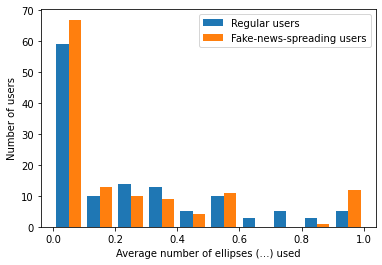

In [226]:
# Average use of ellipsis (truncated tweets)
# plt.figure(figsize=(8, 6), dpi=300)
plt.hist([truthful_punc[:, punc_indices["…"]], fake_punc[:, punc_indices["…"]]],
         label=["Regular users", "Fake-news-spreading users"], hatch="")
plt.ylabel("Number of users")
plt.xlabel("Average number of ellipses (…) used")
plt.legend()

# Sentiment
* Look at average sentiment per user

According to vaderSentiment:
* positive sentiment: compound score >= 0.05
* neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
* negative sentiment: compound score <= -0.05

In [7]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

In [8]:
def polarity_scores(text, analyzer):
    polarity_dict = analyzer.polarity_scores(text)
    return np.asarray([
        polarity_dict['pos'],
        polarity_dict['neu'],
        polarity_dict['neg'],
        polarity_dict['compound'],
    ])

def average_sentiment_per_user(data_array):
    """ Returns Numpy array of the average sentiment of each user; 
    Returned sentiment is an array of [positive, neural, negative, compound] """
    analyzer = SentimentIntensityAnalyzer()
    return np.asarray([
        np.mean([polarity_scores(tweet, analyzer) for tweet in tweet_feed], axis=0) 
        for tweet_feed in data_array
    ])

Text(0.5, 0, 'Average Negative sentiment')

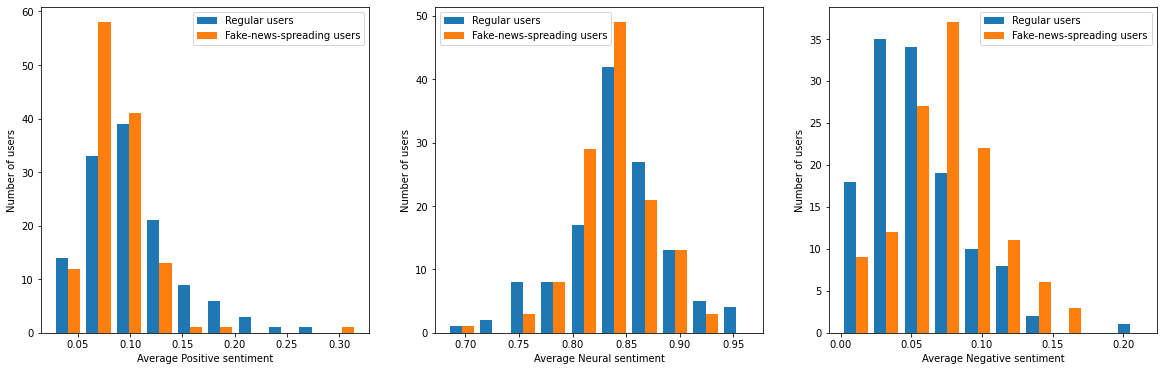

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 6))

truthful_sentiment = average_sentiment_per_user(data_truth)
fake_sentiment = average_sentiment_per_user(data_fake)

for col in range(3):
    ax[col].hist((truthful_sentiment[:, col], fake_sentiment[:, col]), label=("Regular users", "Fake-news-spreading users"))
    ax[col].set_ylabel("Number of users")
    ax[col].legend()
    
ax[0].set_xlabel("Average Positive sentiment")
ax[1].set_xlabel("Average Neural sentiment")
ax[2].set_xlabel("Average Negative sentiment")

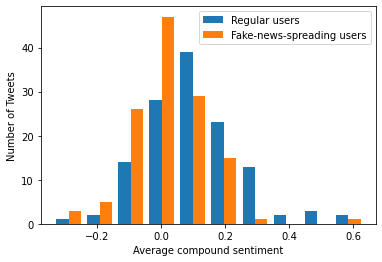

In [10]:
# plt.figure(figsize=(8, 6), dpi=300)
plt.hist((truthful_sentiment[:, 3], fake_sentiment[:, 3]), label=("Regular users", "Fake-news-spreading users"))
plt.ylabel("Number of Tweets")
plt.xlabel("Average compound sentiment")
plt.legend()

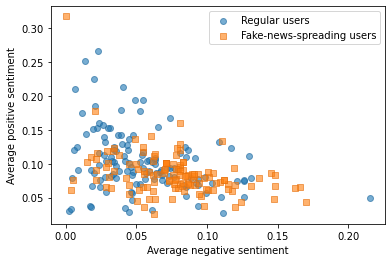

In [24]:
# plt.figure(figsize=(8, 6), dpi=300)
plt.scatter(truthful_sentiment[:, 2], truthful_sentiment[:, 0], label="Regular users",
            color=color_t, alpha=0.6, edgecolors=color_te)
plt.scatter(fake_sentiment[:, 2], fake_sentiment[:, 0], label="Fake-news-spreading users",
            color=color_f, alpha=0.6, edgecolors=color_fe, marker="s")
plt.ylabel("Average positive sentiment")
plt.xlabel("Average negative sentiment")
plt.legend()

Below we concatenate user tweets and get an overall sentiment score for each user (not an averaged one)

In [27]:
# Get the overall sentiment of each users tweets
def all_tweet_compound_scores(data_array):
    return np.asarray(
        [polarity_scores(" ".join(user_tweets), sentiment_analyzer) for user_tweets in data_array])

User sentiment of their concatenated tweets


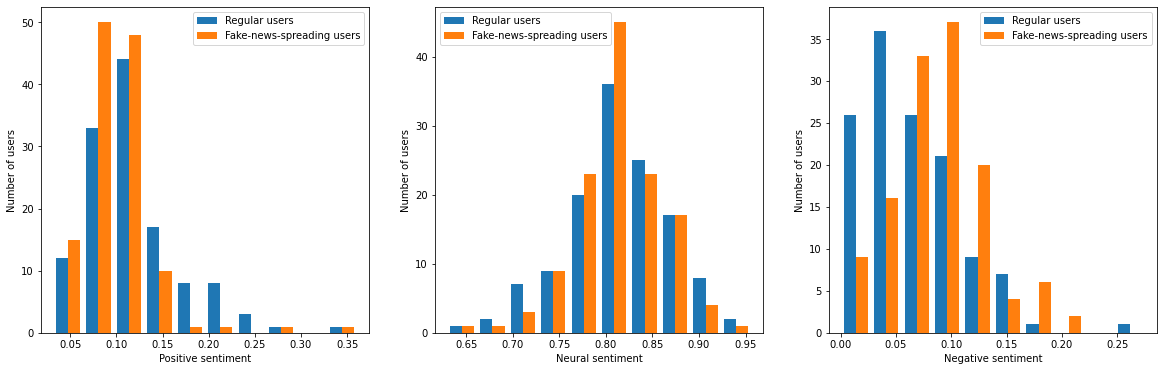

In [28]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 6))

truthful_total_sentiment = all_tweet_compound_scores(data_truth)
fake_total_sentiment = all_tweet_compound_scores(data_fake)

for col in range(3):
    ax[col].hist((truthful_total_sentiment[:, col], fake_total_sentiment[:, col]), 
                 label=("Regular users", "Fake-news-spreading users"))
    ax[col].set_ylabel("Number of users")
    ax[col].legend()
    
ax[0].set_xlabel("Positive sentiment")
ax[1].set_xlabel("Neural sentiment")
ax[2].set_xlabel("Negative sentiment")

print("User sentiment of their concatenated tweets")

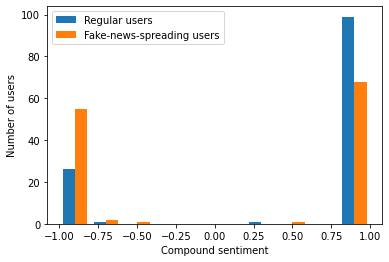

In [29]:
plt.hist((truthful_total_sentiment[:, 3], fake_total_sentiment[:, 3]), 
         label=("Regular users", "Fake-news-spreading users"))
plt.ylabel("Number of users")
plt.xlabel("Compound sentiment")
plt.legend()

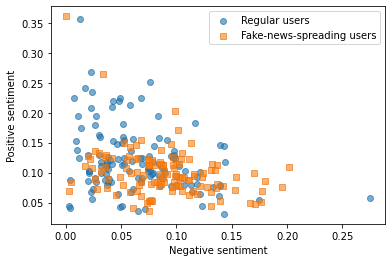

In [30]:
# plt.figure(figsize=(8, 6), dpi=300)
plt.scatter(truthful_total_sentiment[:, 2], truthful_total_sentiment[:, 0], label="Regular users",
            color=color_t, alpha=0.6, edgecolors=color_te)
plt.scatter(fake_total_sentiment[:, 2], fake_total_sentiment[:, 0], label="Fake-news-spreading users",
            color=color_f, alpha=0.6, edgecolors=color_fe, marker="s")
plt.ylabel("Positive sentiment")
plt.xlabel("Negative sentiment")
plt.legend()

Findings:
* Fake users have higher negative sentiment than truthful users
* Higher positive sentiments are normally truthful users

# Readability
* Using the Automated Readability Index - https://en.wikipedia.org/wiki/Automated_readability_index

In [42]:
import textstat

In [43]:
def average_automated_readability_index(data_array):
    """ Returns Numpy array of the average Automated Readability Index of each user """
    return np.asarray([
        np.mean([textstat.automated_readability_index(tweet) for tweet in user_tweets], axis=0) 
        for user_tweets in data_array
    ])

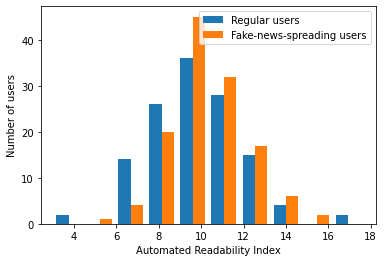

In [44]:
truthful_readability = average_automated_readability_index(data_truth)
fake_readability = average_automated_readability_index(data_fake)

plt.hist((truthful_readability, fake_readability), label=("Regular users", "Fake-news-spreading users"))
plt.ylabel("Number of users")
plt.xlabel("Automated Readability Index")
plt.legend()

Findings:
* Fake news spreaders have more readable tweets than regular users

# Named Entity Recognition
* Use Stanza to extract named entities from tweets

In [45]:
import stanza
nlp = stanza.Pipeline(lang="en", processors="tokenize,ner")
entity_labels = ["PERSON", "NORP", "FAC", "ORG", "GPE", "LOC", "PRODUCT", "EVENT", "WORK_OF_ART", "LAW", 
                       "LANGUAGE", "DATE", "TIME", "PERCENT", "MONEY", "QUANTITY", "ORDINAL", "CARDINAL"]

In [329]:
entity_labels_dict = {k: i for i, k in enumerate(entity_labels)}

def count_named_entities(data_array):
    """ Returns Numpy array of the named entities used in each users tweets """
    
    results = []
    for tweet_feed in data_array:
        user_results = []
        for tweet in tweet_feed:
            tweet_results = [0 for _ in range(len(entity_labels_dict))]
            entities = nlp(clean_text(tweet, remove_tags=True)).ents
            for e in entities:
                tweet_results[entity_labels_dict[e.label_]] += 1
            
            user_results.append(tweet_results)
        
        results.append(user_results)
    
    return np.asarray(results)

In [330]:
truthful_entities = count_named_entities(data_truth)
fake_entities = count_named_entities(data_fake)

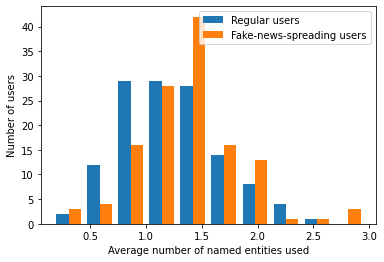

In [365]:
# Number of named entities used by each user
truthful_entities_count = np.mean(np.sum(truthful_entities, axis=2), axis=1)
fake_entities_count = np.mean(np.sum(fake_entities, axis=2), axis=1)

# plt.figure(figsize=(8, 6), dpi=300)
plt.hist((truthful_entities_count, fake_entities_count), label=("Regular users", "Fake-news-spreading users"))
plt.ylabel("Number of users")
plt.xlabel("Average number of named entities used")
plt.legend()

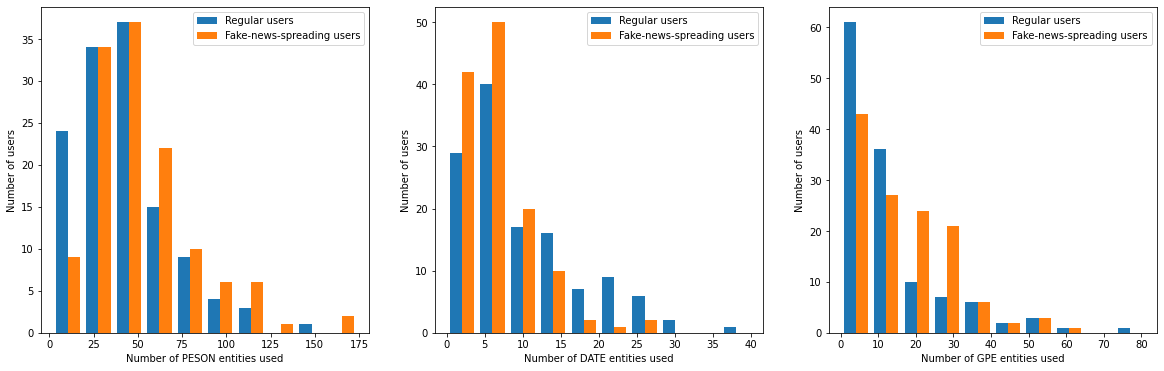

In [350]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 6))

summed_truthful_entities = np.sum(truthful_entities, axis=1)
summed_fake_entities = np.sum(fake_entities, axis=1)

# Number of PERSON entities used by each user
ax[0].hist([summed_truthful_entities[:, entity_labels_dict["PERSON"]], summed_fake_entities[:, entity_labels_dict["PERSON"]]],
            label=("Regular users", "Fake-news-spreading users"))
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Number of PESON entities used")
ax[0].legend()

# Number of DATE entities used by each user
ax[1].hist([summed_truthful_entities[:, entity_labels_dict["DATE"]], summed_fake_entities[:, entity_labels_dict["DATE"]]],
            label=("Regular users", "Fake-news-spreading users"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Number of DATE entities used")
ax[1].legend()

# Number of PERSON entities used by each user
ax[2].hist([summed_truthful_entities[:, entity_labels_dict["GPE"]], summed_fake_entities[:, entity_labels_dict["GPE"]]],
            label=("Regular users", "Fake-news-spreading users"))
ax[2].set_ylabel("Number of users")
ax[2].set_xlabel("Number of GPE entities used")
ax[2].legend()

In [380]:
# Get average number of named entities for each user, and then truthful/fake users in general
truthful_average_entitites = np.mean(np.sum(truthful_entities, axis=1), axis=0)
fake_average_entities = np.mean(np.sum(fake_entities, axis=1), axis=0)

results = list(zip(abs(truthful_average_entitites - fake_average_entities), 
                   truthful_average_entitites, 
                   fake_average_entities, 
                   entity_labels))
results.sort(reverse=True)
df = pd.DataFrame(results, columns=[
    "Difference", "Average usage by RU", "Average usage by FNSU", "Label"]).round(2)
df = df[["Label", "Average usage by RU", "Average usage by FNSU", "Difference"]]
df

,Label,Average usage by RU,Average usage by FNSU,Difference
0,PERSON,42.23,52.04,9.81
1,DATE,9.49,5.96,3.53
2,GPE,13.94,17.08,3.14
3,ORG,37.92,40.82,2.90
4,NORP,4.63,7.28,2.65
5,WORK_OF_ART,3.65,3.07,0.58
6,TIME,1.31,0.81,0.50
7,CARDINAL,3.05,3.34,0.29
8,ORDINAL,1.41,1.13,0.28
9,FAC,1.45,1.28,0.17


In [390]:
for label, ru, fnsu, d in df.values:
    print(label, ru, fnsu, d, sep=" & ", end=" \\\\\n")

PERSON & 42.23 & 52.04 & 9.81 \\
DATE & 9.49 & 5.96 & 3.53 \\
GPE & 13.94 & 17.08 & 3.14 \\
ORG & 37.92 & 40.82 & 2.9 \\
NORP & 4.63 & 7.28 & 2.65 \\
WORK_OF_ART & 3.65 & 3.07 & 0.58 \\
TIME & 1.31 & 0.81 & 0.5 \\
CARDINAL & 3.05 & 3.34 & 0.29 \\
ORDINAL & 1.41 & 1.13 & 0.28 \\
FAC & 1.45 & 1.28 & 0.17 \\
LAW & 0.28 & 0.15 & 0.13 \\
LOC & 1.72 & 1.63 & 0.09 \\
MONEY & 0.03 & 0.08 & 0.05 \\
PRODUCT & 1.76 & 1.8 & 0.03 \\
LANGUAGE & 0.04 & 0.06 & 0.02 \\
PERCENT & 0.01 & 0.02 & 0.01 \\
EVENT & 1.15 & 1.14 & 0.01 \\
QUANTITY & 0.03 & 0.03 & 0.0 \\


Findings:
* Fake news spreaders (on average) refer to PERSON, ORG, NORP, and GPE the most.
* Truthful users seem to refer DATE and TIME more.